In [1]:
#import numpy as np
import autograd.numpy as np
from autograd import grad
from autograd.core import primitive
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
from scipy.misc import imread, imresize, imsave
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as spla
from PIL import Image
import scipy.io
from scipy.signal import correlate2d
import os

import sys
sys.path.insert(0, '../../python')
import caffe

# Model

In [2]:
# set up
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
net = caffe.Net('models/hough_v7.deploy', 'models/hough_v7.caffemodel', caffe.TEST)

# Hough

In [3]:
H = W = 80

theta_min = -90.
theta_max = 90.
rho_min = np.floor(-np.sqrt(H*H+W*W))
rho_max = np.ceil(np.sqrt(H*H+W*W))

THETA = 360
RHO = 480
theta_step = (theta_max-theta_min) / THETA
rho_step = (rho_max-rho_min) / RHO

sin = lambda x: np.sin(x * np.pi / 180)
cos = lambda x: np.cos(x * np.pi / 180)
sin_ = [sin(x) for x in np.arange(theta_min, theta_max, theta_step)]
cos_ = [cos(x) for x in np.arange(theta_min, theta_max, theta_step)]

val_ = np.zeros(H*W*THETA, dtype=float)
ci_ = np.zeros(H*W*THETA, dtype=int)
ro_ = np.zeros(H*W+1, dtype=int)
for idx in xrange(H*W*THETA):
    hw = idx / THETA
    theta_i = idx % THETA
    h, w = hw/W, hw%W
    ro = hw * THETA
    
    rho = h * sin_[theta_i] + w * cos_[theta_i]
    rho_i = int( (rho-rho_min)/rho_step )
    ci = theta_i * RHO + rho_i
    val_[ro+theta_i] = 1.
    ci_[ro+theta_i] = ci
    
    if theta_i == 0:
        ro_[hw] = ro
        if idx == H*W*THETA-1:
            ro[hw+1] = ro + THETA

hb = csr_matrix((val_, ci_, ro_), shape=(H*W, THETA*RHO), dtype=float)

@primitive
def forward_hough(bottom):
    h, w = bottom.shape
    return hb.transpose().dot(bottom.reshape(-1)).reshape((THETA, RHO))

def backward_hough(top_diff):
    h, w = top_diff.shape
    return hb.dot(top_diff.reshape(-1)).reshape((H, W))

def make_grad_forward_hough(top, bottom):
    return lambda top_diff: backward_hough(top_diff)

forward_hough.defgrad(make_grad_forward_hough)

# Normalization

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward_sigmoid(bottom):
    return sigmoid(bottom)

def forward_log(bottom):
    return np.log(1+bottom)

def forward_gn(bottom, std=2):
    h, w = bottom.shape
    m = np.mean(bottom)
    s = np.std(bottom)
    top = (bottom - m) / s * std
    return top

# ensure hft_tgt_small has been defined
def loss(prob_small):
    pred = forward_sigmoid(forward_gn(forward_hough(prob_small)))
    tgt = forward_sigmoid(forward_gn(forward_hough(tgt_small)))
    return -np.sum(tgt*np.log(pred) +
                   (1-tgt)*np.log(1-pred))

fb_gn = grad(loss)

# Thick

In [43]:
img = imread('data.old/train/005600.png', mode='RGB')
lmap = imread('data.old/train/005600.ppm')
# img = imread('data/train/03700.png', mode='RGB')
# lmap = imread('data/train/03700.ppm')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
lmap_ = lmap[np.newaxis, :, :] / 255.
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# net.blobs['label'].reshape(1, *lmap_.shape)
# net.blobs['label'].data[...] = lmap_
# run net and take argmax for prediction
net.forward()
#out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
#out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
# out6 = net.blobs['sigmoid-dsn6'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

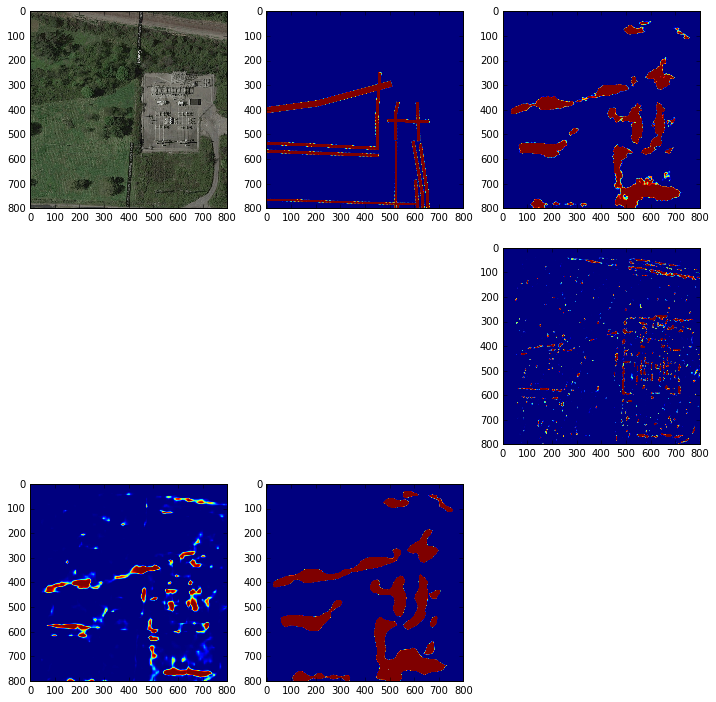

In [44]:
plt.figure(figsize=(12, 12))
plt.subplot(331)
plt.imshow(img)
plt.subplot(332)
plt.imshow(lmap)
plt.subplot(333)
plt.imshow(fuse)

# plt.subplot(334)
# plt.imshow(out1)
# plt.subplot(335)
# plt.imshow(out2)
plt.subplot(336)
plt.imshow(out3)
plt.subplot(337)
plt.imshow(out4)
plt.subplot(338)
plt.imshow(out5)
# plt.subplot(339)
# plt.imshow(out6)

In [5]:
print 'conv4_3'
print net.params['conv4_3'][0].data.min(), net.params['conv4_3'][0].data.max()
print net.blobs['conv4_3'].data.min(), net.blobs['conv4_3'].data.max()
print
print 'upsample_8'
print net.params['score-dsn4'][0].data.min(), net.params['score-dsn4'][0].data.max(), net.params['score-dsn4'][0].data.mean()
print net.blobs['score-dsn4'].data.min(), net.blobs['score-dsn4'].data.max()
print net.params['upsample_8'][0].data.min(), net.params['upsample_8'][0].data.max()
print net.params['upsample_8'][1].data.min(), net.params['upsample_8'][1].data.max()
print
print 'conv5_3'
print net.params['conv5_3'][0].data.min(), net.params['conv5_3'][0].data.max()
print net.blobs['conv5_3'].data.min(), net.blobs['conv5_3'].data.max()
print
print 'upsample_16'
print net.params['score-dsn5'][0].data.min(), net.params['score-dsn5'][0].data.max(), net.params['score-dsn5'][0].data.mean()
print net.blobs['score-dsn5'].data.min(), net.blobs['score-dsn5'].data.max()
print net.params['upsample_16'][0].data.min(), net.params['upsample_16'][0].data.max()
print net.params['upsample_16'][1].data.min(), net.params['upsample_16'][1].data.max()
print
print 'conv6_3'
print net.params['conv6_3'][0].data.min(), net.params['conv6_3'][0].data.max()
print net.blobs['conv6_3'].data.min(), net.blobs['conv6_3'].data.max()
print
print 'upsample_32'
print net.params['score-dsn6'][0].data.min(), net.params['score-dsn6'][0].data.max(), net.params['score-dsn6'][0].data.mean()
print net.blobs['score-dsn6'].data.min(), net.blobs['score-dsn6'].data.max()
print net.params['upsample_32'][0].data.min(), net.params['upsample_32'][0].data.max()
print net.params['upsample_32'][1].data.min(), net.params['upsample_32'][1].data.max()
print
print out6.min(), out6.max()
print net.params['new-score-weighting'][0].data
print
print 'nla_hf_dsn4'
print net.params['nla_hf_dsn4'][0].data

conv4_3
-0.128793 0.263091
0.0 544.402

upsample_8
-0.0564423 0.0207082 -0.00156453
-127.267 12.3592
0.00390625 0.878906
0.0 0.0

conv5_3
-0.580573 0.753429
0.0 20537.9

upsample_16
-0.0398107 0.0102778 0.00103147
-2164.48 1930.26
0.000976562 0.938477
0.0 0.0

conv6_3


KeyError: 'conv6_3'

0.0 1.0
0.0 3796.0
-817.5 1298.76


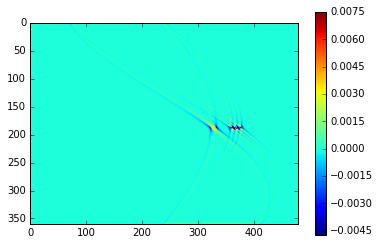

In [25]:
print net.blobs['label'].data.min(), net.blobs['label'].data.max()
print net.blobs['hf_label'].data.min(), net.blobs['hf_label'].data.max()
print net.blobs['le_hf_label'].data.min(), net.blobs['le_hf_label'].data.max()
hf = np.squeeze(net.blobs['le_hf_label'].data).copy()
hf /= THETA * RHO
restore = backward_hough(-hf)
plt.imshow(hf)
plt.colorbar()

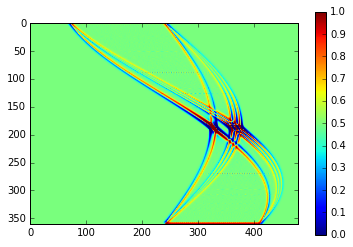

In [8]:
hf_label = np.squeeze(net.blobs['le_hf_label'].data).copy()
m = hf_label.mean()
s = hf_label.std()
hf_label = (hf_label - m) / s
hf_label = forward_sigmoid(hf_label)
plt.imshow(hf_label)
plt.colorbar()

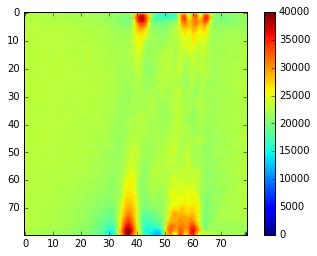

In [15]:
restore = backward_hough(imresize(hf.T, [THETA, RHO]))
plt.imshow(restore)
plt.colorbar()

# Hough

In [9]:
prob = fuse
# prob = out6
tgt = lmap
H, W = 80, 80
prob_small = imresize(prob, [W, H]).astype(float)/255.
tgt_small = imresize(tgt, [W, H]).astype(float)/255.
#imsave('prob.ppm', fuse)
#imsave('tgt.ppm', lmap)
#imsave('prob-small.ppm', prob_small)
#imsave('tgt-small.ppm', tgt_small)

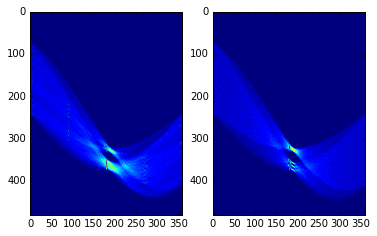

In [8]:
hft_prob_small = forward_hough(prob_small)
hft_tgt_small = forward_hough(tgt_small)
plt.subplot(121)
plt.imshow(hft_prob_small.T)
plt.subplot(122)
plt.imshow(hft_tgt_small.T)

# Local enhancement

In [12]:
tgt_small = tgt_small  # ensure it's defined
ks = 8
scale = 3

def normalize(a):
    amin, amax = a.min(), a.max()
    r = (a-amin)/(amax-amin)
    return r

@primitive
def forward_le(bottom, ks=ks, scale=scale):
    kernel = 1./ks**2 * np.ones([ks, ks])
    x = bottom
    ex = correlate2d(x, kernel, mode='same', boundary='symm')
    top = (x-ex)*scale
    return top

def backward_le(top_diff, bottom, ks=ks, scale=scale):
    kernel = 1./ks**2 * np.ones([ks, ks])
    dex = correlate2d(bottom, kernel, mode='same', boundary='symm')
    bottom_diff = top_diff * scale * (1 - dex)
    return bottom_diff
    
def make_grad_forward_le(top, bottom):
    return lambda top_diff: backward_le(top_diff, bottom)    

forward_le.defgrad(make_grad_forward_le)

# cross entropy
def loss(prob_small):
    pred = forward_sigmoid(forward_le(forward_hough(prob_small)))
    tgt = forward_sigmoid(forward_le(forward_hough(tgt_small)))
    return -np.sum(tgt*np.log(pred) + (1-tgt)*np.log(1-pred))

# euclidean
# def loss(prob_small):
#     h, w = prob_small.shape
#     pred = forward_le(forward_hough(prob_small))
#     tgt = forward_le(forward_hough(tgt_small))
#     return -1./(2*h*w) * np.sum((pred-tgt)**2)

fb_le = grad(loss)

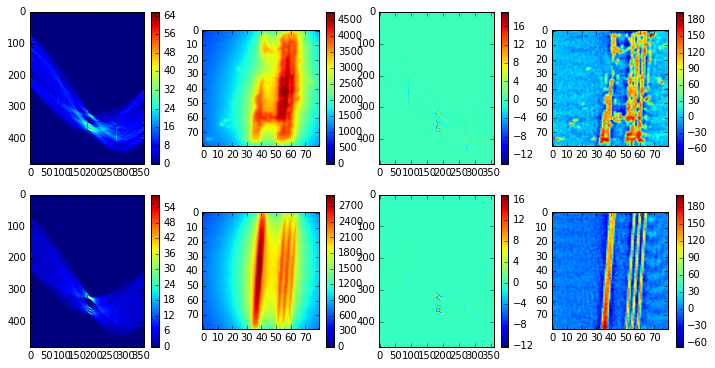

In [11]:
le_hft_prob = forward_le(hft_prob_small)
le_hft_tgt = forward_le(hft_tgt_small)

prob_restore = backward_hough(hft_prob_small)
tgt_restore = backward_hough(hft_tgt_small)
prob_le = backward_hough(le_hft_prob)
tgt_le = backward_hough(le_hft_tgt)

plt.figure(figsize=(12, 6))
plt.subplot(241)
plt.imshow(hft_prob_small.T)
plt.colorbar()
plt.subplot(242)
plt.imshow(prob_restore)
plt.colorbar()
plt.subplot(243)
plt.imshow(le_hft_prob.T)
plt.colorbar()
plt.subplot(244)
plt.imshow(prob_le)
plt.colorbar()

plt.subplot(245)
plt.imshow(hft_tgt_small.T)
plt.colorbar()
plt.subplot(246)
plt.imshow(tgt_restore)
plt.colorbar()
plt.subplot(247)
plt.imshow(le_hft_tgt.T)
plt.colorbar()
plt.subplot(248)
plt.imshow(tgt_le)
plt.colorbar()

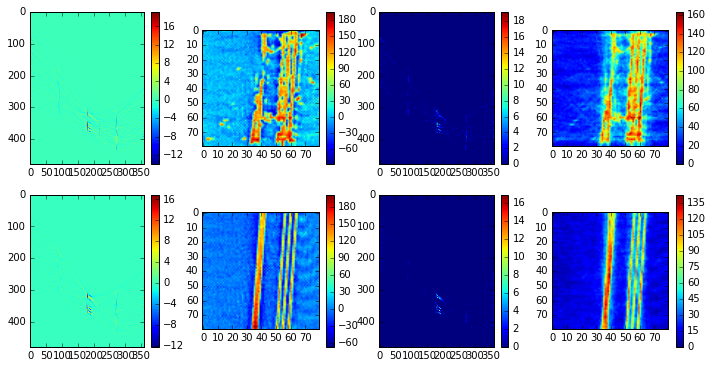

In [19]:
clean_hft_prob = le_hft_prob.copy()
clean_hft_prob[clean_hft_prob<1] = 0
clean_prob = backward_hough(clean_hft_prob)
clean_hft_tgt = le_hft_tgt.copy()
clean_hft_tgt[clean_hft_tgt<1] = 0
clean_tgt = backward_hough(clean_hft_tgt)

plt.figure(figsize=(12, 6))

plt.subplot(241)
plt.imshow(le_hft_prob.T)
plt.colorbar()
plt.subplot(242)
plt.imshow(prob_le)
plt.colorbar()
plt.subplot(243)
plt.imshow(clean_hft_prob.T)
plt.colorbar()
plt.subplot(244)
plt.imshow(clean_prob)
plt.colorbar()

plt.subplot(245)
plt.imshow(le_hft_tgt.T)
plt.colorbar()
plt.subplot(246)
plt.imshow(tgt_le)
plt.colorbar()
plt.subplot(247)
plt.imshow(clean_hft_tgt.T)
plt.colorbar()
plt.subplot(248)
plt.imshow(clean_tgt)
plt.colorbar()

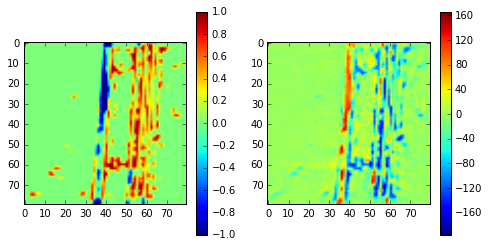

In [20]:
prob_diff = fb(prob_small)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(prob_small-tgt_small)
plt.colorbar()
plt.subplot(122)
plt.imshow(prob_diff)
plt.colorbar()

# Global normalization

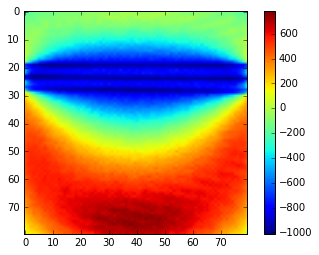

In [16]:
err = fb_gn(np.ones([H, W])*.01)
plt.imshow(err)
plt.colorbar()

# Local normalization

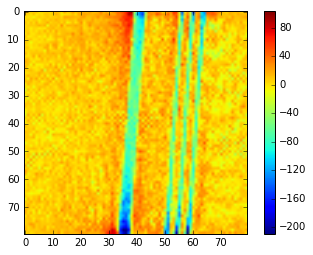

In [13]:
err = fb_le(np.ones([H, W])*.01)
plt.imshow(err)
plt.colorbar()

# Misc

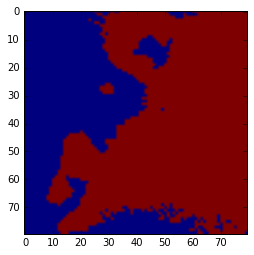

In [15]:
plt.imshow(prob_diff>0)

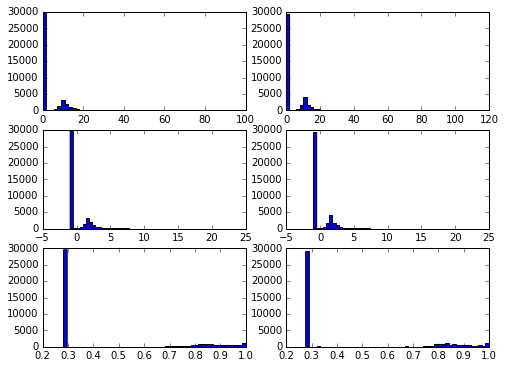

In [16]:
plt.figure(figsize=(8, 6))
bins = 50
plt.subplot(321)
vbins, ebins, patches = plt.hist(hft_prob_small.reshape(-1), bins=bins)
plt.subplot(322)
_, _, _ = plt.hist(hft_tgt_small.reshape(-1), bins=bins)
plt.subplot(323)
_, _, _ = plt.hist(gn_prob.reshape(-1), bins=bins)
plt.subplot(324)
_, _, _ = plt.hist(gn_tgt.reshape(-1), bins=bins)
plt.subplot(325)
_, _, _ = plt.hist(sig_gn_prob.reshape(-1), bins=bins)
plt.subplot(326)
_, _, _ = plt.hist(sig_gn_tgt.reshape(-1), bins=bins)

# Post processing

In [40]:
fp = imread('data/misc/fp.png', mode='RGB')
in_ = np.array(fp, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred_fp = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()

pos = imread('data/train/000000.png', mode='RGB')
gt_pos = imread('data/train/000000.ppm')
in_ = np.array(pos, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred_pos = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()

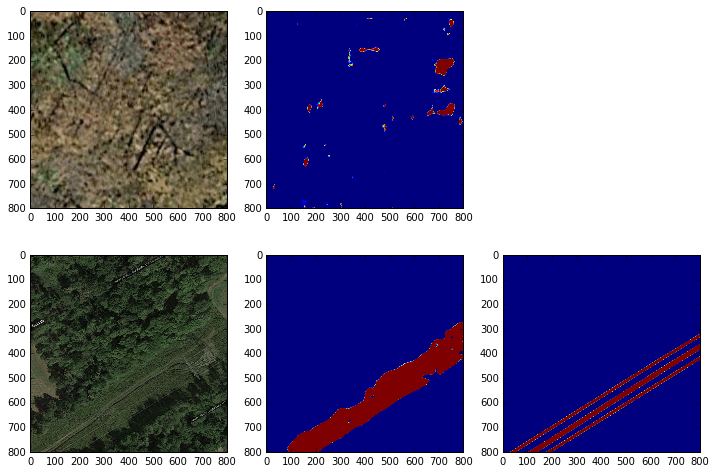

In [41]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(fp)
plt.subplot(232)
plt.imshow(pred_fp)
plt.subplot(234)
plt.imshow(pos)
plt.subplot(235)
plt.imshow(pred_pos)
plt.subplot(236)
plt.imshow(gt_pos)

In [42]:
HH, WW = 800, 800
THETA, RHO = 360, 480
theta_step = 180./THETA
rho_min = np.floor(-np.sqrt(HH*HH+WW*WW))
rho_max = np.ceil(np.sqrt(HH*HH+WW*WW))
rho_step = (rho_max-rho_min)/RHO
thetas = (np.arange(THETA) * theta_step - 90) / 180 * np.pi
sin_ = np.sin(thetas)
cos_ = np.cos(thetas)

def get_feature(img, hft, y, x):
    rhos = y * sin_ + x * cos_ - rho_min
    rhos = (rhos/rho_step).astype(int)
    val = hft[range(THETA), rhos]
    return np.mean(val), np.std(val), np.median(val)
#     return np.sort(val)

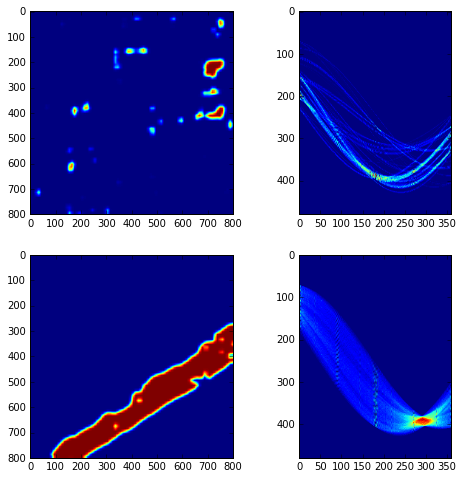

In [43]:
HH, WW = pred_fp.shape
pred_fp_small = imresize(pred_fp, [WW/10, HH/10])
pred_fp = imresize(pred_fp_small, [WW, HH]) / 255.
hft_fp = forward_hough(pred_fp_small)
hft_fp /= hft_fp.max()  # important normalization

pred_pos_small = imresize(pred_pos, [WW/10, HH/10])
pred_pos = imresize(pred_pos_small, [WW, HH]) / 255.
hft_pos = forward_hough(pred_pos_small)
hft_pos /= hft_pos.max()  # important normalization

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pred_fp)
plt.subplot(222)
plt.imshow(hft_fp.T)
plt.subplot(223)
plt.imshow(pred_pos)
plt.subplot(224)
plt.imshow(hft_pos.T)

## SVM for line back in hough

In [44]:
from sklearn import svm

clf = svm.SVC(class_weight={0: 2, 1: 1})

X = []
y = []

# gen pos
print 'Generating important pos/neg...'
for i in xrange(HH):
    for j in xrange(WW):
        if pred_pos[i, j] > .5 and gt_pos[i, j] > .5:
            feat = get_feature(pred_pos, hft_pos, i, j)
            X.append(feat)
            y.append(1)
        if pred_fp[i, j] > .3:
            feat = get_feature(pred_fp, hft_fp, i, j)
            X.append(feat)
            y.append(0)

# gen neg
print 'Generating unimportant neg...'
for i in xrange(0, HH, 80):
    for j in xrange(0, WW, 80):
        # fp
        if pred_pos[i, j] < .5 and gt_pos[i, j] < .5:
            feat = get_feature(pred_pos, hft_pos, i, j)
            X.append(feat)
            y.append(0)
        # neg
        if pred_fp[i, j] < .3:
            feat = get_feature(pred_fp, hft_fp, i, j)
            X.append(feat)
            y.append(0)

print 'Fitting...'
X = np.array(X)
y = np.array(y)
clf.fit(X, y)

Generating important pos/neg...
Generating unimportant neg...
Fitting...


SVC(C=1.0, cache_size=200, class_weight={0: 4, 1: 1}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## New example

In [47]:
fp = imread('data/misc/fp2.png', mode='RGB')
in_ = np.array(fp, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred_fp = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()

pos = imread('data/train/000100.png', mode='RGB')
gt_pos = imread('data/train/000100.ppm')
in_ = np.array(pos, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred_pos = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()

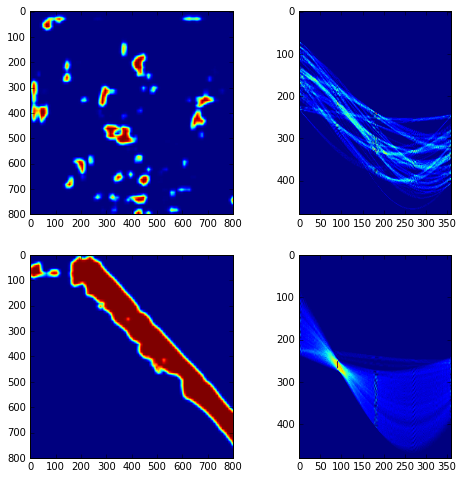

In [48]:
HH, WW = pred_fp.shape
pred_fp_small = imresize(pred_fp, [WW/10, HH/10])
pred_fp = imresize(pred_fp_small, [WW, HH]) / 255.
hft_fp = forward_hough(pred_fp_small)
hft_fp /= hft_fp.max()  # important normalization

pred_pos_small = imresize(pred_pos, [WW/10, HH/10])
pred_pos = imresize(pred_pos_small, [WW, HH]) / 255.
hft_pos = forward_hough(pred_pos_small)
hft_pos /= hft_pos.max()  # important normalization

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pred_fp)
plt.subplot(222)
plt.imshow(hft_fp.T)
plt.subplot(223)
plt.imshow(pred_pos)
plt.subplot(224)
plt.imshow(hft_pos.T)

In [49]:
HH, WW = pred_pos.shape

print 'Preparing pred_pos...'
X = []
ii, jj = np.nonzero(pred_pos>0.3)
for i, j in zip(ii, jj):
    feat = get_feature(pred_pos, hft_pos, i, j)
    X.append(feat)
print 'Predicting pred_pos...'
X = np.array(X)
y = clf.predict(X)
pred_pos[ii, jj] = y

print 'Preparing pred_fp...'
X = []
ii, jj = np.nonzero(pred_fp>0.3)
for i, j in zip(ii, jj):
    feat = get_feature(pred_fp, hft_fp, i, j)
    X.append(feat)
print 'Predicting pred_fp...'
X = np.array(X)
y = clf.predict(X)
pred_fp[ii, jj] = y

Preparing pred_pos...
Predicting pred_pos...
Preparing pred_fp...
Predicting pred_fp...


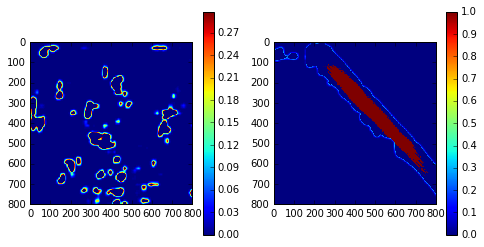

In [50]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(pred_fp)
plt.colorbar()
plt.subplot(122)
plt.imshow(pred_pos)
plt.colorbar()

# Clean up approach

In [ ]:
def cleanup(hf):
    r = hf.copy()
    r[r<r.mean()] = 0
    
    num = np.sum(r>0)
    m = np.sum(r) / num
    med = np.median(r[r>0])
    print m, med
    s = np.sqrt(np.sum(r**2)/num - m**2)
    
    r[r<med*4] = 0
    return r

clean_fp = cleanup(hft_fp)
fp_restore = backward_hough(clean_fp)
fp_restore = imresize(fp_restore, [WW, HH])

clean_pos = cleanup(hft_pos)
pos_restore = backward_hough(clean_pos)
pos_restore = imresize(pos_restore, [WW, HH])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.imshow(hft_fp)
plt.colorbar()
plt.subplot(232)
plt.imshow(clean_fp)
plt.colorbar()
plt.subplot(233)
plt.imshow(fp_restore)
plt.colorbar()

plt.subplot(234)
plt.imshow(hft_pos)
plt.colorbar()
plt.subplot(235)
plt.imshow(clean_pos)
plt.colorbar()
plt.subplot(236)
plt.imshow(pos_restore)
plt.colorbar()